In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import yfinance as yf
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.integrate import trapz
from scipy.misc import derivative
from scipy.integrate import simps
from scipy.optimize import curve_fit
import math
from scipy.integrate import solve_ivp

## Extract Risk Neutral PDF from call option prices

We download data for call options written on SPDR S&P 500 ETF Trust (SPY) on 29/09/2020 with expiration date after 20 days on 19/10/20, with strike prices ranging from \$170 to \$425. We create a new column “midprice” from the bid/ask prices, this are the ones that we re going to use in our analysis. The stock price on 29/09/2020 was $332.


In [56]:
calls = pd.read_excel("SPY_191020exp_290920.xlsx", sheet_name="call")
calls["midprice"] = (calls.bid + calls.ask)/2
calls = calls[calls.midprice > 0]
calls

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
0,170,0.00,0.0,163.70,164.06,146 x 146,0,0,163.880
1,175,0.00,0.0,158.70,159.06,146 x 146,0,0,158.880
2,180,0.00,0.0,153.69,154.05,146 x 102,0,0,153.870
3,185,0.00,0.0,148.70,149.04,146 x 102,0,0,148.870
4,190,0.00,0.0,143.70,144.06,146 x 146,0,0,143.880
...,...,...,...,...,...,...,...,...,...
110,405,0.01,0.0,0.00,0.01,0 x 11065,0,28,0.005
111,410,0.02,0.0,0.00,0.01,0 x 8620,0,200,0.005
112,415,0.01,0.0,0.00,0.01,0 x 8630,0,5,0.005
113,420,0.02,0.0,0.00,0.01,0 x 8641,0,55,0.005


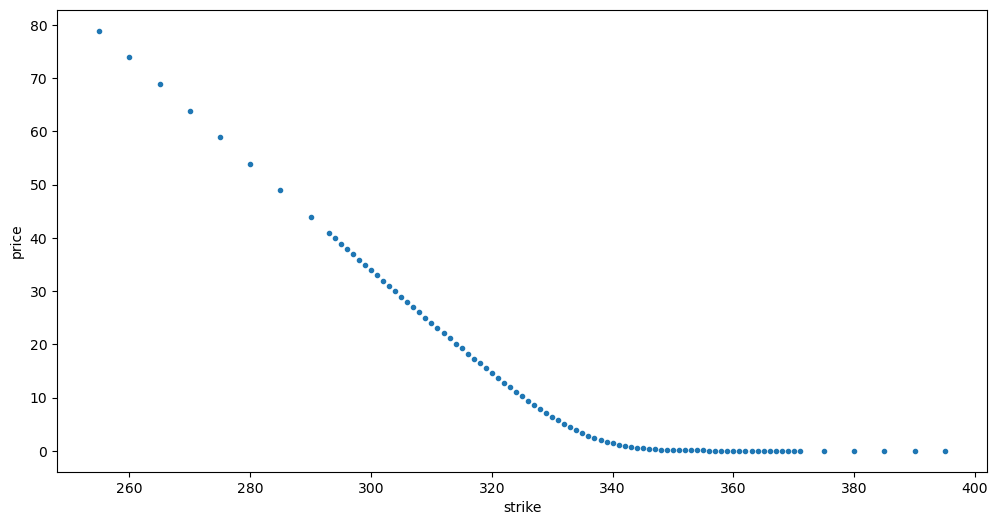

In [57]:
calls_sub = calls[(calls.strike > 250) & (calls.strike < 400)]
plt.figure(figsize=(12,6))
plt.plot(calls_sub.strike, calls_sub.midprice, ".");
plt.xlabel("strike")
plt.ylabel("price")
#plt.savefig("call_prices.png", dpi=400)
plt.show()

### Implied Volatility Surface

In the sequel we want to construct the implied volatility surface induced by the given call option prices (“midprice”). We clean our dataset by dropping the NA values and then using the remaining option prices we calculate the implied volatilities using the Black & Scholes model. For these implied volatilities and using a linear interpolation scheme we derive the implied volatility curve.

In [58]:
def call_value(S, K, sigma, t=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv 

In [59]:
S = 332
t = 3/52
calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=500), axis=1)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_6060\2692504730.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_6060\2692504730.py:4: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_6060\2692504730.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


In [60]:
def plot_vol_smile(calls, savefig=False):
    plt.figure(figsize=(9,6))
    plt.plot(calls.strike, calls.iv, ".")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    if savefig:
        plt.savefig("vol_smile.png",dpi=300)
    plt.show()

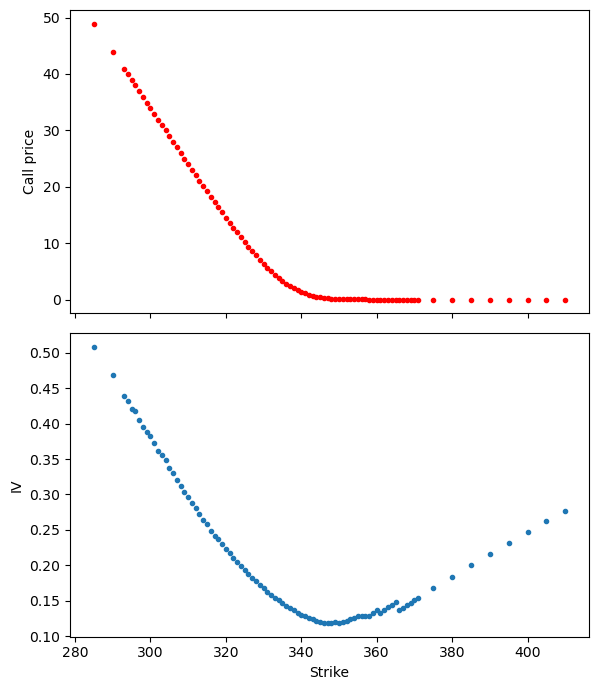

In [61]:
calls_no_na = calls.dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
ax1.plot(calls_no_na.strike, calls_no_na.midprice, "r.")
ax1.set_ylabel("Call price")
ax2.plot(calls_no_na.strike, calls_no_na.iv, ".")
ax2.set_ylabel("IV")
ax2.set_xlabel("Strike")
plt.tight_layout()
# plt.savefig("calls_to_iv.png", dpi=400)
plt.show()

In [62]:
calls_clean = calls.dropna().copy()
calls_clean["iv"] = gaussian_filter1d(calls_clean.iv, 3)

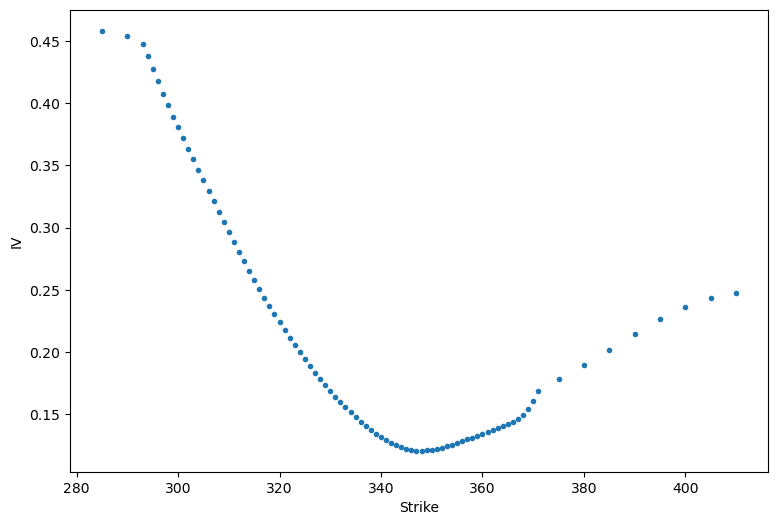

In [63]:
plot_vol_smile(calls_clean)

In [64]:
calls_clean = calls_clean[(calls_clean.strike > 300) & (calls_clean.strike < 375)]

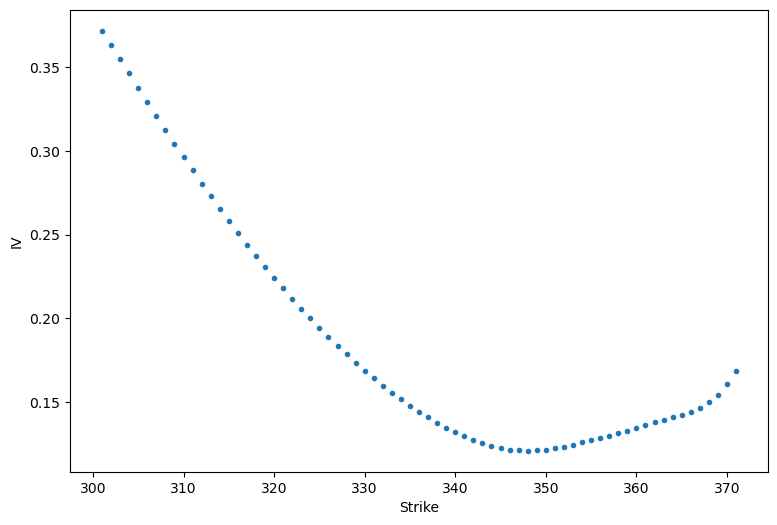

In [65]:
plot_vol_smile(calls_clean, savefig=False)

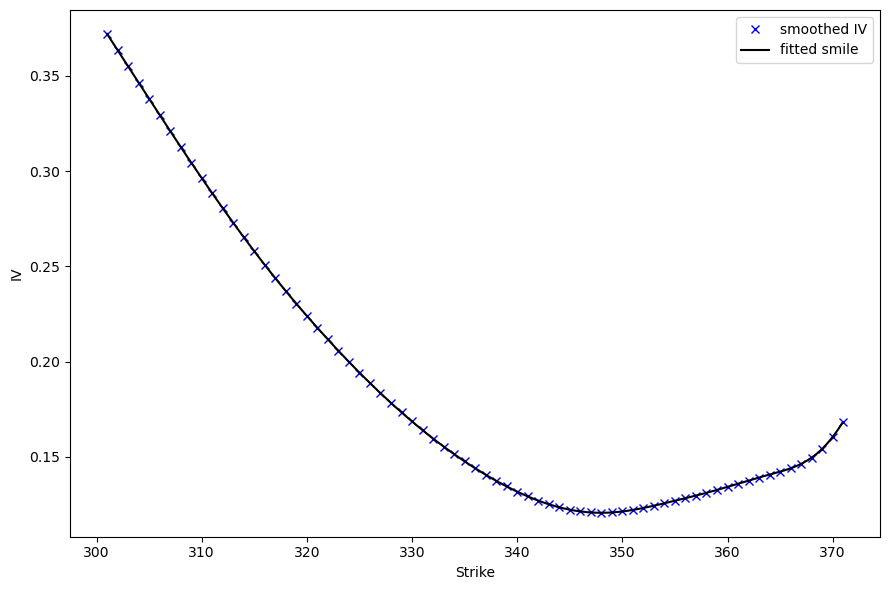

In [66]:
plt.figure(figsize=(9,6))
vol_surface = scipy.interpolate.interp1d(calls_clean.strike, calls_clean.iv, kind="cubic",
                                 fill_value="extrapolate")
x_new = np.arange(calls_clean.strike.min(), calls_clean.strike.max(), 0.1)
plt.plot(calls_clean.strike, calls_clean.iv, "bx", x_new, vol_surface(x_new), "k-");
plt.legend(["smoothed IV", "fitted smile"], loc="best")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.tight_layout()
# plt.savefig("SPY_smile.png", dpi=300)
plt.show()

### Risk neutral PDF from Breeden - Litzenberger formula

Then by using the interpolated implied volatilities, as well as the ones that we calculated from the real call prices, we calculate the corresponding call options prices. Next, from these prices we use the Breeden-Litzenberger formula in order to derive the risk-neutral density.

In [67]:
C_interp = call_value(S, x_new, vol_surface(x_new), t)

In [68]:
first_deriv = np.gradient(C_interp, x_new)
second_deriv = np.gradient(first_deriv, x_new)

In [69]:
def pdf(Krange, S, t=0, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, vol_surface(Krange), t, r)
    first_deriv = np.gradient(Crange, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
    return np.exp(r * t) * second_deriv

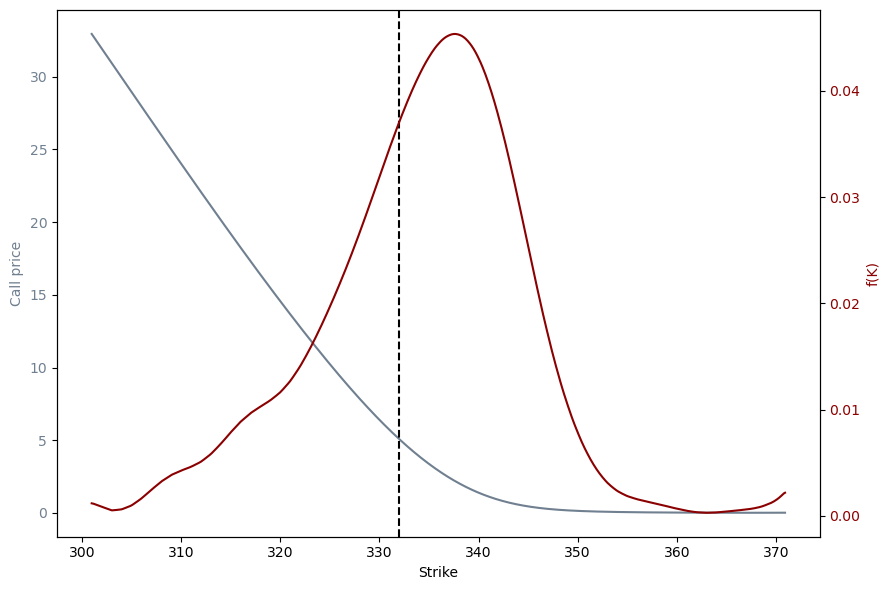

In [70]:
fig, ax1 = plt.subplots(figsize=(9,6))

col="slategrey"
ax1.set_xlabel('Strike')
ax1.set_ylabel('Call price', color=col)
ax1.plot(x_new, C_interp, color=col)
ax1.tick_params(axis='y', labelcolor=col)
ax1.axvline(332, color="k", linestyle="--")

ax2 = ax1.twinx()
col = 'darkred'
ax2.set_ylabel('f(K)', color=col)
ax2.plot(x_new, pdf(x_new, S, t), color=col)
ax2.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
# plt.savefig("volspace_pdf.png", dpi=300)
plt.show()

We notice that the extreme values give irregular results, which cannot be trusted due to the sparsity of call option prices with strike far away from the money. So we drop the values outside the interval [320,360] and what remains is ~90% of the distribution (area under the curve ~0.9). 

In [71]:
data = np.vstack([x_new, pdf(x_new, S, t)]).T
data = data[(data[:, 0] < 360) & (data[:, 0] > 320)]
k, curve_pdf = np.hsplit(data, 2)

In [72]:
# Flatten the arrays if they are 2D
k_flat = k.flatten()
curve_pdf_flat = curve_pdf.flatten()

# Create a 2D array for the original PDF
original_pdf = np.column_stack((k_flat, curve_pdf_flat))

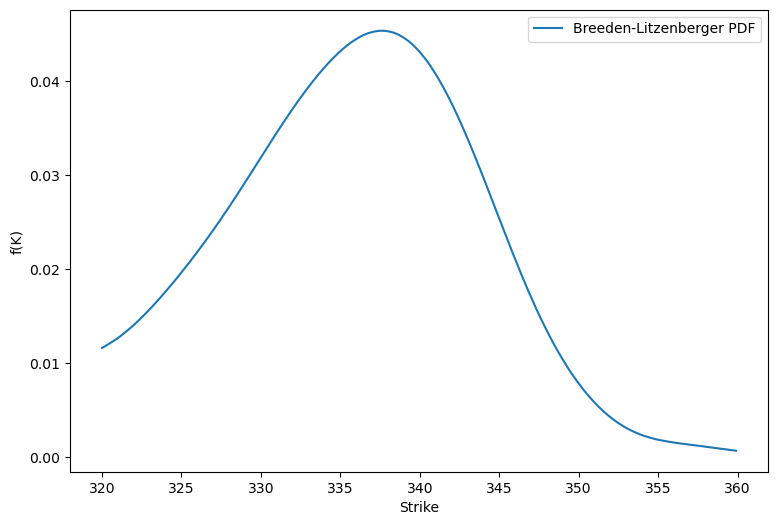

In [73]:
plt.figure(figsize=(9,6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1])
# plt.savefig("breeden_litzenberger_pdf.png", dpi=300)
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Breeden-Litzenberger PDF"], loc="best")
plt.show()


In [74]:
#Measure the area under the pdf curve
def compute_area(pdf_array):
    x_values = pdf_array[:, 0]
    pdf_values = pdf_array[:, 1]
    area = trapz(pdf_values, x_values)
    return area


area_under_rn_pdf = compute_area(original_pdf)
print("Area under the PDF:", area_under_rn_pdf)


Area under the PDF: 0.8973977092102928


Now, in order to get a valid distribution we extrapolate on the left using exponential decay and derive a smoother representation of the risk neutral pdf.

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_6060\2468099346.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x - c))


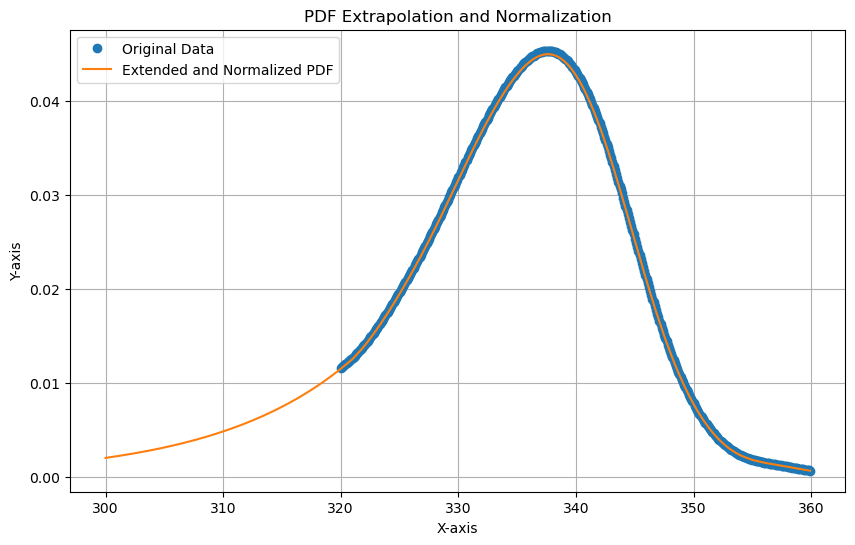

In [75]:
x_original = original_pdf[:, 0]
y_original = original_pdf[:, 1]

# Define the exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * (x - c))

# Use the leftmost points of the original data to fit the exponential decay
left_points_x = x_original[:10]  
left_points_y = y_original[:10]
params, _ = curve_fit(exp_decay, left_points_x, left_points_y, p0=(1, 1, x_original[0]))

# Define the range for extrapolation
x_min_extrapolate = 300  

# Generate new x values for extrapolation
x_extrapolate = np.linspace(x_min_extrapolate, x_original[0], num=100, endpoint=False)

# Generate new y values using the fitted exponential decay
y_extrapolate = exp_decay(x_extrapolate, *params)

# Combine the extrapolated points with the original data
extrapolated_pdf = np.column_stack((x_extrapolate, y_extrapolate))
new_pdf = np.vstack((extrapolated_pdf, original_pdf))

# Normalize the curve so the total area is 1
x_values = new_pdf[:, 0]
y_values = new_pdf[:, 1]
area = simps(y_values, x_values)
y_values_normalized = y_values / area

# Replace the y-values in new_pdf with normalized values
new_pdf[:, 1] = y_values_normalized
rn_pdf = new_pdf

plt.figure(figsize=(10, 6))
plt.plot(x_original, y_original, 'o', label='Original Data')
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], label='Extended and Normalized PDF')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('PDF Extrapolation and Normalization')
plt.legend()
plt.grid(True)
plt.show()


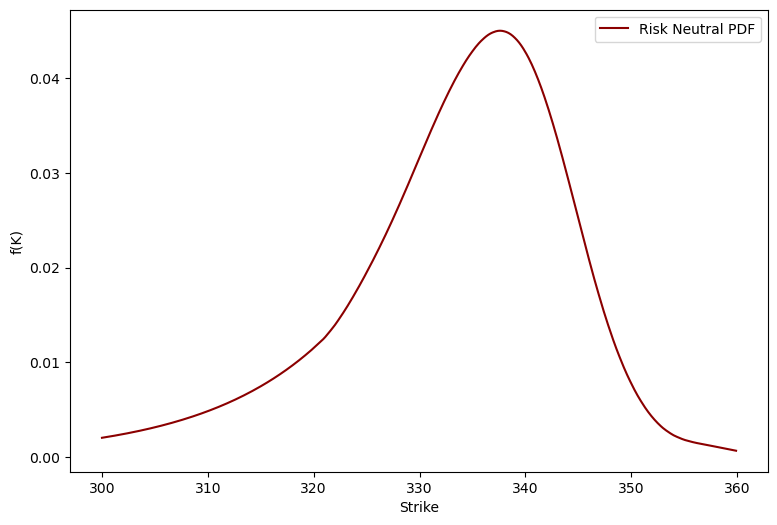

In [76]:
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Risk Neutral PDF"], loc="best")
# plt.savefig("risk_neutral_pdf.png", dpi=300)
plt.show()


## Derive implied risk aversion and construct optimal payoffs

After we extracted the market-implied pdf for the underlying, we now proceed in the main part of the application of the quantitative structuring algorithm we are studying. 

First, we define some functions that will be used later.

In [110]:
def call_option_payoff(spot_price, strike_price):
    return np.maximum(spot_price - strike_price, 0)

def put_option_payoff(spot_price, strike_price):
    return np.maximum(strike_price - spot_price, 0)

def straddle_payoff(spot_price, strike_price):
    call_payoff = call_option_payoff(spot_price, strike_price)
    put_payoff = put_option_payoff(spot_price, strike_price)
    return call_payoff + put_payoff

def strangle_payoff(spot_price, call_strike, put_strike):
    call_payoff = call_option_payoff(spot_price, call_strike)
    put_payoff = put_option_payoff(spot_price, put_strike)
    return call_payoff + put_payoff

In [155]:
def risk_reversal_type_payoff(x):
    a1 = 0.07/9
    b1 = 1-329*a1
    c = 329*a1+b1
    a2 = 0.19/12
    b2 = 1-348*a2
    
    if x < 329:
        return a1*x + b1
    elif 329 <= x < 348:
        return c
    else:
        return a2*x+ b2

In [156]:
def digital_payoff(x):
    if x < 339:
        return 1.025
    elif 339 <= x < 340:
        return 1.025
    else:
        return 0.98

In [77]:
# Calculates the payoff of a reverse convertible.
def reverse_convertible_payoff(S_T, S_0, P, C, K):
    """
    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.

    Returns:
    Total payoff of the reverse convertible.
    """
    # Adjusted asset value based on the initial price
    adjusted_asset_value = P * S_T / S_0

    # The investor receives the adjusted asset value if it's below the principal, 
    # otherwise they receive the principal amount.
    asset_or_principal = min(P, adjusted_asset_value)

    # Total payoff is the sum of the coupon payment and the minimum of principal or adjusted asset value.
    return C + asset_or_principal

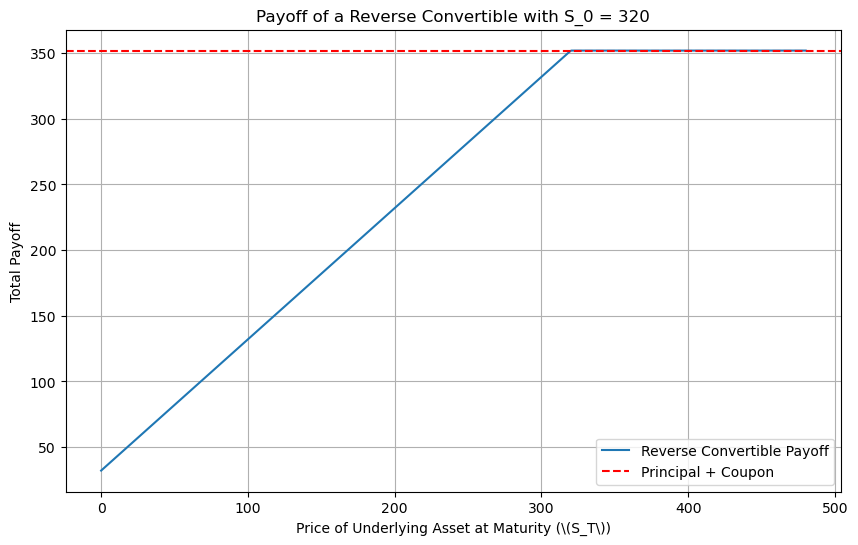

In [78]:
#PLOT EXAMPLE 

# Parameters
S_0 = 320  # Initial price of the underlying asset
P = S_0  # Principal amount (equal to S_0)
C = P * 0.10  # Coupon payment (10% of principal)
K = P  # Strike price equal to the principal

# Price of the underlying asset at maturity ranging from 0 to 1.5 times the initial price
S_T_values = np.linspace(0, 1.5 * S_0, 500)

# Calculate payoffs
payoffs = [reverse_convertible_payoff(S_T, S_0, P, C, K) for S_T in S_T_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S_T_values, payoffs, label='Reverse Convertible Payoff')
plt.axhline(y=P + C, color='r', linestyle='--', label='Principal + Coupon')
plt.title('Payoff of a Reverse Convertible with S_0 = 320')
plt.xlabel('Price of Underlying Asset at Maturity (\(S_T\))')
plt.ylabel('Total Payoff')
plt.legend()
plt.grid(True)
plt.show()


In [79]:
#Function that is equal to F'(x)/F(x) for the reverse convertible payoff F(x)
def derivative_to_payoff_ratio_rc(S_T, S_0, P, C, K):
    """
    Parameters:
    S_T: Price of the underlying asset at maturity.
    S_0: Initial price of the underlying asset.
    P: Principal amount.
    C: Coupon payment.
    K: Strike price.

    Returns:
    Ratio of the derivative of the payoff to the payoff itself.
    """
    # Calculate the reverse convertible payoff
    payoff = reverse_convertible_payoff(S_T, S_0, P, C, K)

    # Derivative is 1 before the strike and 0 after
    derivative = 1 if S_T < K else 0

    # Avoid division by zero
    if payoff == 0:
        return 0

    # Ratio calculation
    ratio = derivative / payoff if S_T < K else 0

    return ratio

In [80]:
#Function that is equal to f(x)/f'(x) for given function f (named 'growth_optimizer_payoff' here)
def ratio_function(x, growth_optimizer_payoff):
    # Function to compute the derivative
    def derivative_of_growth_optimizer(x):
        return derivative(growth_optimizer_payoff, x, dx=1e-6)
    
    # Function to compute the ratio of the original function to its derivative
    original_value = growth_optimizer_payoff(x)
    derivative_value = derivative_of_growth_optimizer(x)
    return original_value / derivative_value if derivative_value != 0 else np.inf

In [81]:
#Function returns [f(x)/f'(x)]*[F'(x)/F(x)] for inputs f(x) (growth_optimizer_payoff) and F'(x)/F(x) (general_payoff_ratio) 
def relative_risk_aversion(x, growth_optimizer_payoff, general_payoff_ratio):
    return ratio_function(x, growth_optimizer_payoff) * general_payoff_ratio(x)

### Change pdf beliefs

In the core of the structuring algorithm, lies the idea of custom beliefs an investor might have for the distribution of the underlying after some analysis he has conducted. More specifically, what matters most is how this belief compares to the market implied distribution (risk neutral pdf). Now we will consider some cases that represent possible beliefs of the investor.

#### Shift the pdf

First, consider that an investor who has the view that the expected value of the underlying at maturity should be higher than the one suggested by the market. In a simple case, that could be expressed by shifting the risk neutral pdf by some units to the right. That corresponds to a believed distribution which is biased towards higher prices for the underlying.

In [82]:
k_flat = rn_pdf[:, 0].flatten()  # This is the x-values of rn_pdf
curve_pdf_flat = rn_pdf[:, 1].flatten()  # This is the y-values of rn_pdf

In [83]:
# Shift the rn_pdf to the right by "shift" units
shift = 5
shifted_pdf = np.column_stack((k_flat + shift, curve_pdf_flat))

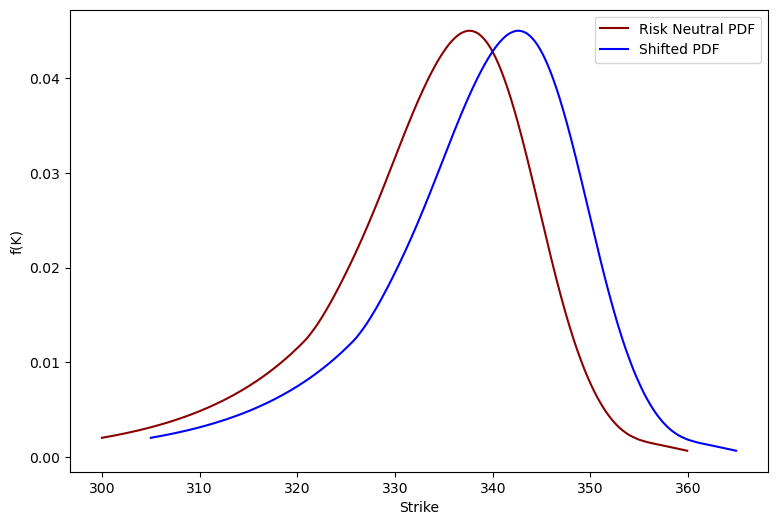

In [84]:
# Plot the original and shifted PDFs
plt.figure(figsize=(9, 6))

# Plot the original PDF (rn_pdf)
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], "darkred", label="Risk Neutral PDF")

# Plot the shifted PDF
plt.plot(shifted_pdf[:, 0], shifted_pdf[:, 1], "blue", label="Shifted PDF")

plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(loc="best")
plt.show()


 Now we compute the optimal payoff for a growth optimizing investor as suggested by the theory: $ f(x) = \dfrac{b(x)}{m(x)} $, where $m(x)$ is the market-implied pdf and $b(x)$ is the pdf believed by the investor.

In [85]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
rn_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the shifted PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the shifted strike prices
rn_pdf_values_at_shifted = rn_pdf_interp(shifted_pdf[:, 0])

# Handle division by zero by replacing zeros with a very small number
division = np.where(rn_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / rn_pdf_values_at_shifted, 0)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_shift = interp1d(shifted_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_6060\3301309537.py:11: RuntimeWarning: divide by zero encountered in true_divide
  division = np.where(rn_pdf_values_at_shifted != 0, shifted_pdf[:, 1] / rn_pdf_values_at_shifted, 0)


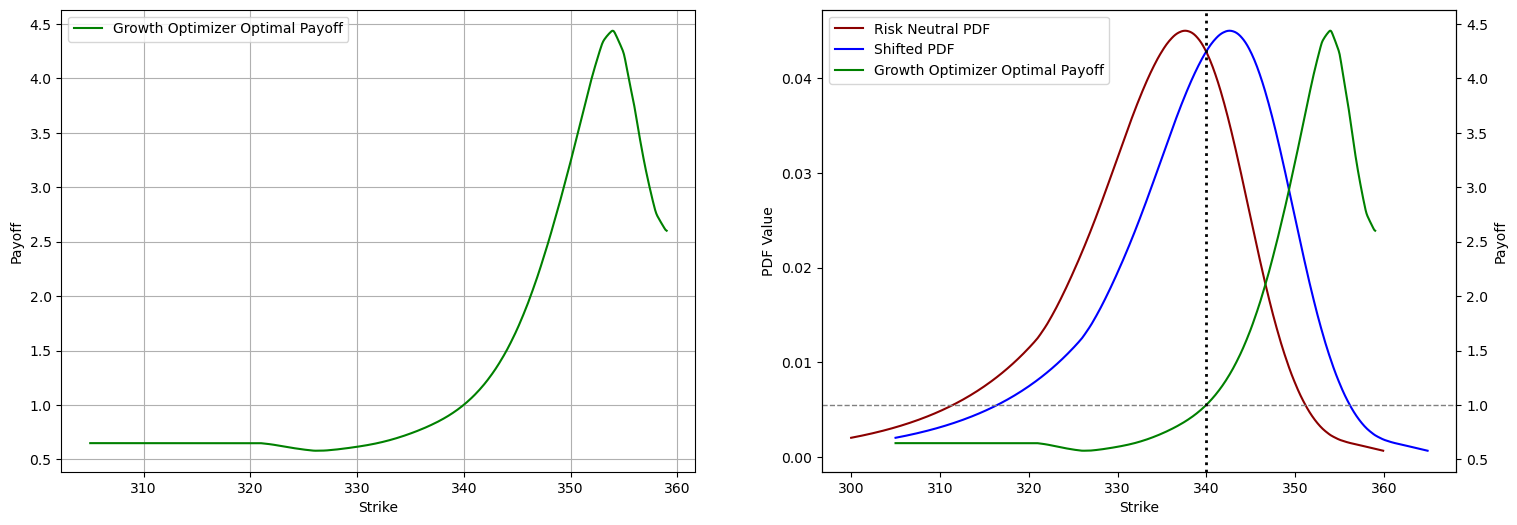

In [86]:
end_range = min(360, np.max(shifted_pdf[:, 0]))
strike_range = np.linspace(np.min(shifted_pdf[:, 0]), 359, 500)

# Plot the growth optimizer payoff function
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(strike_range, growth_optimizer_payoff_shift(strike_range), 'green', label='Growth Optimizer Optimal Payoff')
plt.xlabel("Strike")
plt.ylabel("Payoff")
plt.legend(loc="best")
# plt.savefig("growth_optimizer_payoff_shift.png", dpi=300)
plt.grid(True)

plt.subplot(1,2,2)
line1, = plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Risk Neutral PDF')
line2, = plt.plot(shifted_pdf[:, 0], shifted_pdf[:, 1], 'blue', label='Shifted PDF')

plt.xlabel("Strike")
plt.ylabel("PDF Value")

ax2 = plt.gca().twinx()

strike_range = np.linspace(np.min(shifted_pdf[:, 0]), 359, 1000)
fractions = growth_optimizer_payoff_shift(strike_range)
line3, = ax2.plot(strike_range, fractions, 'green', label='Growth Optimizer Optimal Payoff')

ax2.set_ylabel("Payoff")
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1)

handles = [line1, line2, line3]
labels = [h.get_label() for h in handles]

plt.legend(handles, labels, loc='best')

tolerance = 0.001  
equal_points = strike_range[np.abs(fractions - 1) < tolerance]
for x in equal_points:
    plt.axvline(x=x, color='black', linestyle=':', linewidth=2)
    
    
plt.show()

In [87]:
def maximum_of_function(f):
    def negative_function(x):
        return -f(x)

    # Find the maximum using minimize_scalar within the bounds of your data
    result = minimize_scalar(negative_function, bounds=(np.min(growth_optimizer_payoff_shift.x), np.max(growth_optimizer_payoff_shift.x)), method='bounded')

    # The maximum value and the point where it is achieved
    max_value = -result.fun
    max_point = result.x
    
    return max_value, max_point

#### Change volatility

In the same manner as before, we now consider an investor that has a view on the volatily of the underlying. We choose a scenario where the investor expects that the volatility is larger than the one the market infers. This can be expressed by choosing a distribution with fatter tails.

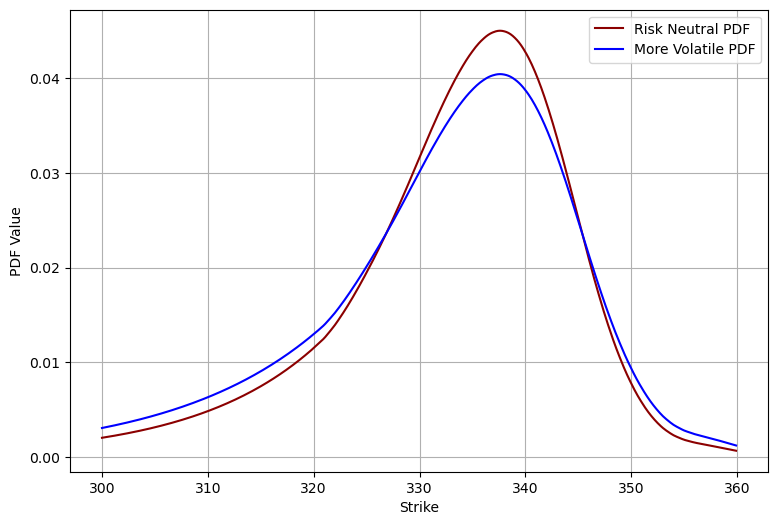

In [96]:
# Increase volatility with a non-linear transformation
volatility_increase = 1.2  # Adjust this for more or less volatility
new_pdf_values = np.copy(rn_pdf[:, 1])
new_pdf_values = np.power(new_pdf_values, 1 / volatility_increase)

# Normalize the new PDF
original_area = trapz(rn_pdf[:, 1], rn_pdf[:, 0])
new_area = trapz(new_pdf_values, rn_pdf[:, 0])
new_pdf_values *= (original_area / new_area)

# Create the more/less volatile PDF
more_volatile_pdf = np.column_stack((rn_pdf[:, 0], new_pdf_values))

# Plot both PDFs for comparison
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Risk Neutral PDF')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue', label='More Volatile PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.grid(True)
plt.show()

Again we derive the growth optimal payoff for this scenario and we observe that this payoff is similar to the market standards (when dealing with volatility) straddles and strangles.

In [97]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_more_volatile = original_pdf_interp(more_volatile_pdf[:, 0])

# Perform the division
division = more_volatile_pdf[:, 1] / np.where(original_pdf_values_at_more_volatile != 0, 
                                              original_pdf_values_at_more_volatile, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_vol = interp1d(more_volatile_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

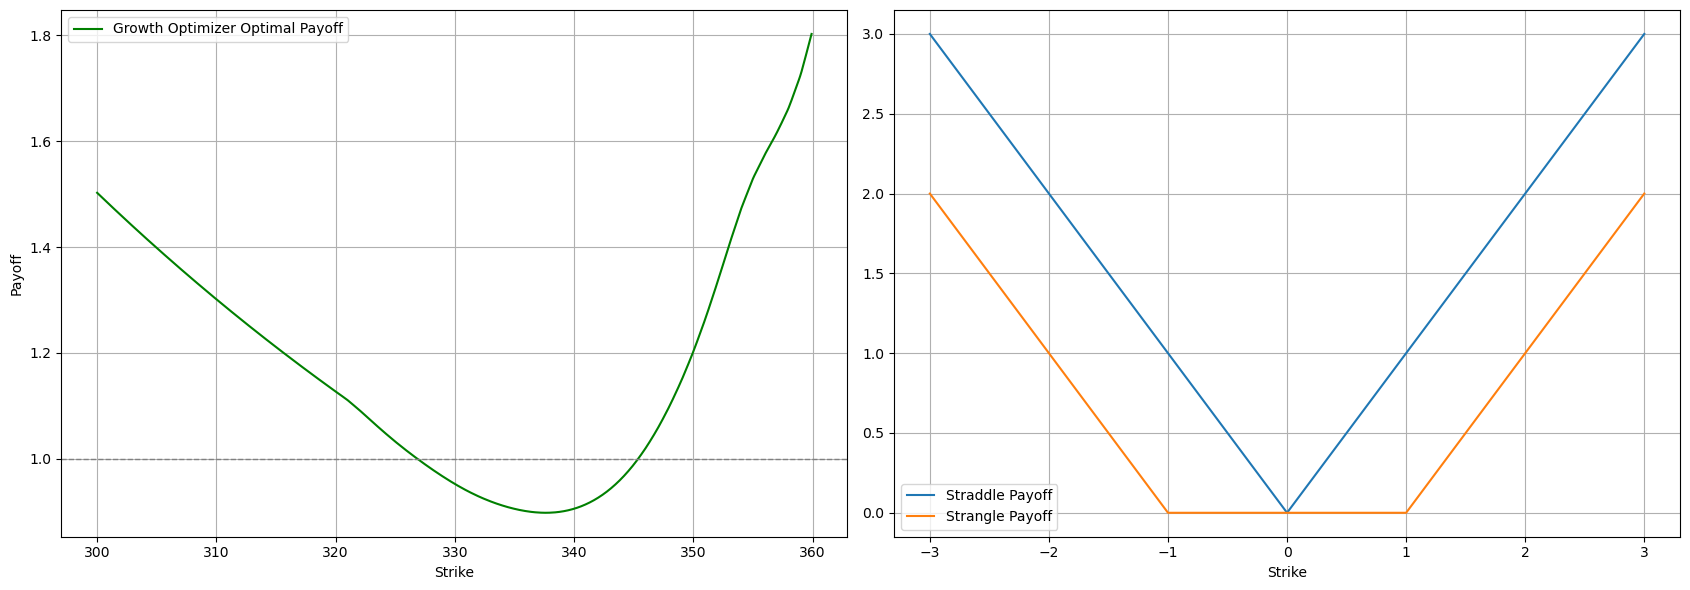

In [128]:
mu = 0
sigma = 1
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
straddle_strike = 0
strangle_put_strike = -1
strangle_call_strike = 1

straddle_payoff_values = straddle_payoff(x, straddle_strike)
strangle_payoff_values = strangle_payoff(x, strangle_call_strike, strangle_put_strike)

plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 500)
plt.plot(strike_range, growth_optimizer_payoff_vol(strike_range), 'green', label='Growth Optimizer Optimal Payoff')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Strike")
plt.ylabel("Payoff")
plt.legend(loc="best")
# plt.savefig("growth_optimizer_payoff_vol.png", dpi=300)
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x, straddle_payoff_values, label='Straddle Payoff')
plt.plot(x, strangle_payoff_values, label='Strangle Payoff')
plt.xlabel('Strike')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


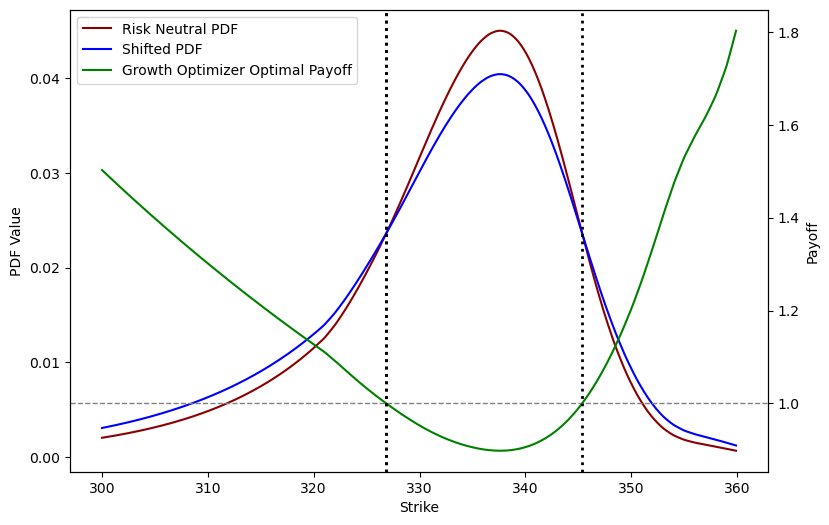

In [134]:
#PLOT TOGETHER WITH SCALED PDFs

plt.figure(figsize=(9,6))

# Plot the Original PDF and More Volatile PDF
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred')
plt.plot(more_volatile_pdf[:, 0], more_volatile_pdf[:, 1], 'blue')

plt.xlabel("Strike")
plt.ylabel("PDF Value")
plt.legend(loc="upper left")

# Create secondary y-axis for the fraction
ax2 = plt.gca().twinx()

# Calculate and Plot the Fraction of More Volatile to Original PDF on the secondary y-axis
strike_range = np.linspace(np.min(more_volatile_pdf[:, 0]), np.max(more_volatile_pdf[:, 0]), 1000)
fractions = growth_optimizer_payoff_vol(strike_range)
ax2.plot(strike_range, fractions, 'green', label='Fraction of More Volatile to Original PDF')

# Add a horizontal line at y=1 for reference on the secondary y-axis
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel("Payoff")
ax2.legend(loc="upper right")

handles = [line1, line2, line3]
labels = [h.get_label() for h in handles]

plt.legend(handles, labels, loc='best')

# Add more visible vertical dotted lines where the fraction is approximately 1
tolerance = 0.001  # Very small tolerance for precision
equal_points = strike_range[np.abs(fractions - 1) < tolerance]
for x in equal_points:
    plt.axvline(x=x, color='black', linestyle=':', linewidth=2)

plt.show()


#### Shift + change vol (reverse convertible)

Now let's focus on a more specific case. Assume that we have an investor who buys a reverse convertible note with strike at the money. What such an investor usually expects is that the volatility will be low and that the price of the underlying might make a slight rise (not larger than the coupon value).

In [139]:
def compute_expectation(pdf_array):
    x_values = pdf_array[:, 0]
    pdf_values = pdf_array[:, 1]
    x_times_pdf = x_values * pdf_values
    expectation = trapz(x_times_pdf, x_values)
    return expectation

expectation_value_rn = compute_expectation(rn_pdf)
print("The risk neutral distribution expects that the price of the underlying at maturity will be:", expectation_value_rn)

The risk neutral distribution expects that the price of the underlying at maturity will be: 333.4983464535587


So the market (risk neutral pdf) expects that the price of the underline will slightly rise from 332 to 333.5. Now lets assume that the investor believes that the price will rise to 336.2 (as mean) and the volatility will be smaller than the market-implied. Then his belief might be expressed as follows.

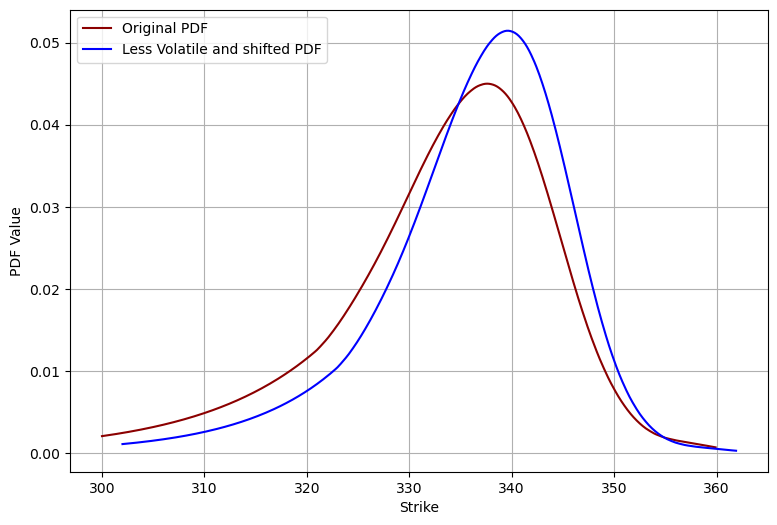

In [142]:
# Decrese volatility with a non-linear transformation
volatility_increase = 0.8  
new_pdf_values = np.copy(rn_pdf[:, 1])
new_pdf_values = np.power(new_pdf_values, 1 / volatility_increase)

# Normalize the new PDF
original_area = trapz(rn_pdf[:, 1], rn_pdf[:, 0])
new_area = trapz(new_pdf_values, rn_pdf[:, 0])
new_pdf_values *= (original_area / new_area)

# Create the less volatile and shifted PDF
shift = 2
rc_pdf = np.column_stack((rn_pdf[:, 0] + shift, new_pdf_values))

# Plot both PDFs for comparison
plt.figure(figsize=(9,6))
plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Risk Neutral PDF')
plt.plot(rc_pdf[:, 0], rc_pdf[:, 1], 'blue', label='Less Volatile and shifted PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
expectation_value_rc = compute_expectation(rc_pdf)
print("The investor expects that the price of the underlying at maturity will be:", expectation_value_rc)

The investor expects that the price of the underlying at maturity will be: 336.2381369282854


We compute the optimal payoff in this case (according to the theory) for a growth optimizing investor.

In [144]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_rc_pdf = original_pdf_interp(rc_pdf[:, 0])

# Perform the division
division = rc_pdf[:, 1] / np.where(original_pdf_values_at_rc_pdf != 0, 
                                              original_pdf_values_at_rc_pdf, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_rc = interp1d(rc_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

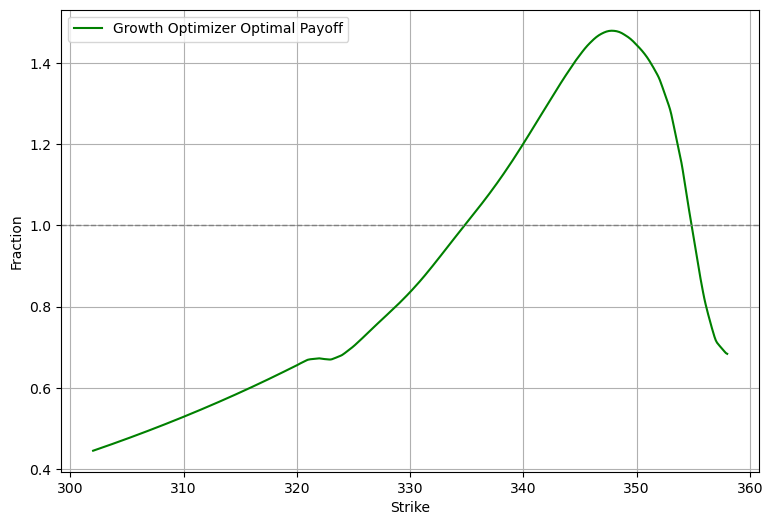

In [147]:
plt.figure(figsize=(9,6))
strike_range = np.linspace(np.min(rc_pdf[:, 0]), 358, 500)
plt.plot(strike_range, growth_optimizer_payoff_rc(strike_range), 'green', label='Growth Optimizer Optimal Payoff')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Strike")
plt.ylabel("Fraction")
plt.legend(loc="best")
# plt.savefig("less_volatile_shifted_payoff.png", dpi=300)
plt.grid(True)
plt.show()

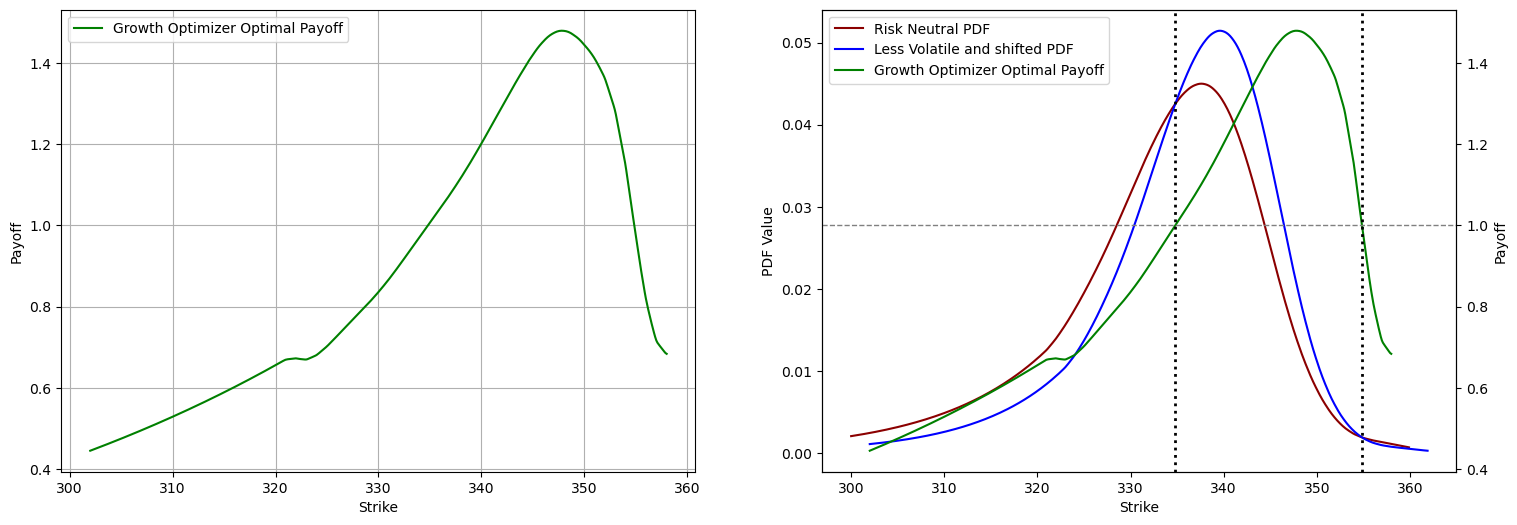

In [179]:
# Plot the growth optimizer payoff function
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
strike_range = np.linspace(np.min(rc_pdf[:, 0]), 358, 500)
plt.plot(strike_range, growth_optimizer_payoff_rc(strike_range), 'green', label='Growth Optimizer Optimal Payoff')
plt.xlabel("Strike")
plt.ylabel("Payoff")
plt.legend(loc="best")
# plt.savefig("growth_optimizer_payoff_shift.png", dpi=300)
plt.grid(True)

plt.subplot(1,2,2)
line1, = plt.plot(rn_pdf[:, 0], rn_pdf[:, 1], 'darkred', label='Risk Neutral PDF')
line2, = plt.plot(rc_pdf[:, 0], rc_pdf[:, 1], 'blue', label='Less Volatile and shifted PDF')

plt.xlabel("Strike")
plt.ylabel("PDF Value")

ax2 = plt.gca().twinx()

fractions = growth_optimizer_payoff_rc(strike_range)
line3, = ax2.plot(strike_range, fractions, 'green', label='Growth Optimizer Optimal Payoff')

ax2.set_ylabel("Payoff")
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=1)

handles = [line1, line2, line3]
labels = [h.get_label() for h in handles]

plt.legend(handles, labels, loc='best')

tolerance = 0.002  
equal_points = strike_range[np.abs(fractions - 1) < tolerance]
for x in equal_points:
    plt.axvline(x=x, color='black', linestyle=':', linewidth=2)
    
    
plt.show()

#### Less skewed volatility smile

Up to this point, we only looked at examples where the investor's beliefs were directly depicted on the distribution of the underlying. However this is not necessary. We will now look at a case were the investor has a specific view on the implied volatility curve.

In this scenario we suppose that the investor believes that the volatility smile is less skewed than the market-implied one. We adjust the volatility curve according to this expectation and using again the Breeden-Litzenberger formula we derive the corresponding density. Similarly as before, due to lack of option strikes away from the money, we are missing 10% of the distribution on the left tail. Contrarily to what we did before though we now won't extrapolate to complete the pdf, since this would require to make additional assumptions for the relationship of the two distributions (risk neutral and adjusted) that we prefered to avoid here.

In [158]:
strikes = calls_clean.strike
iv = calls_clean.iv

atm_strike = 332

# Find the index of the ATM strike
atm_index = np.where(strikes == atm_strike)[0][0]

# Define the smoothing factor for IV adjustments
smoothing_factor = -0.005  # Smaller values mean less skew

# Adjust IVs smoothly around the ATM strike
# Here we decrease the IV before the ATM and increase it after the ATM
adjusted_iv = np.copy(iv)
for i in range(len(strikes)):
    if i < atm_index:
        adjusted_iv[i] -= (atm_index - i) * smoothing_factor * (iv.iloc[atm_index] - iv.iloc[i])
    elif i > atm_index:
        adjusted_iv[i] += (i - atm_index) * smoothing_factor * (iv.iloc[i] - iv.iloc[atm_index])

# Make sure the adjusted IV at ATM is the same as the original
adjusted_iv[atm_index] = iv.iloc[atm_index]

# Create the adjusted volatility surface
adjusted_vol_surface = scipy.interpolate.interp1d(strikes, adjusted_iv, kind="cubic", fill_value="extrapolate")

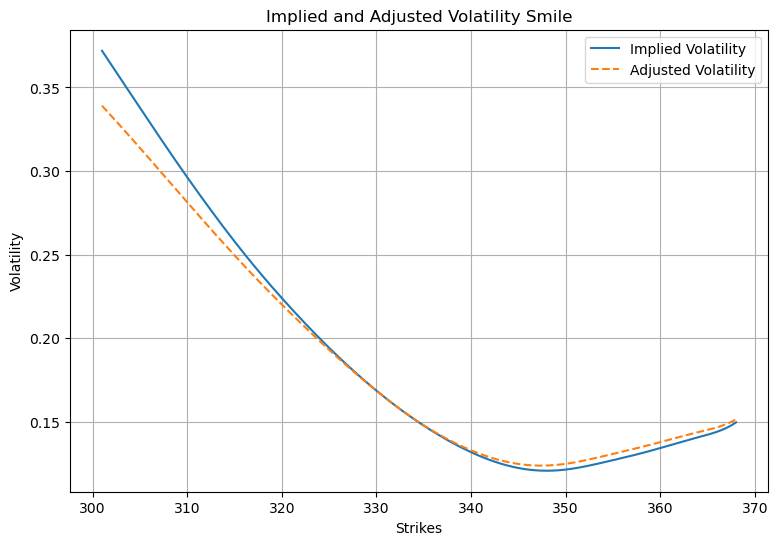

In [169]:
x_range = np.linspace(strikes.min(), 368, 1000)

plt.figure(figsize=(9,6))
plt.plot(x_range, vol_surface(x_range), label='Implied Volatility')
plt.plot(x_range, adjusted_vol_surface(x_range), label='Adjusted Volatility', linestyle='--')
plt.title('Implied and Adjusted Volatility Smile')
plt.xlabel('Strikes')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [161]:
C_interp_adjusted = call_value(S, x_new, adjusted_vol_surface(x_new), t)

first_deriv2 = np.gradient(C_interp_adjusted, x_new)
second_deriv2 = np.gradient(first_deriv2, x_new)

def pdf2(Krange, S, t=0, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, adjusted_vol_surface(Krange), t, r)
    first_deriv2 = np.gradient(Crange, x_new, edge_order=0)
    second_deriv2 = np.gradient(first_deriv2, x_new, edge_order=0)
    return np.exp(r * t) * second_deriv2

In [162]:
data2 = np.vstack([x_new, pdf2(x_new, S, t)]).T
data2 = data2[(data2[:, 0] < 360) & (data2[:, 0] > 320)]
k, curve_pdf2 = np.hsplit(data2, 2)

In [166]:
# Flatten the arrays if they are 2D
k_flat = k.flatten()
curve_pdf_flat2 = curve_pdf2.flatten()

# Create a 2D array for the original PDF
original_pdf2 = np.column_stack((k_flat, curve_pdf_flat2))

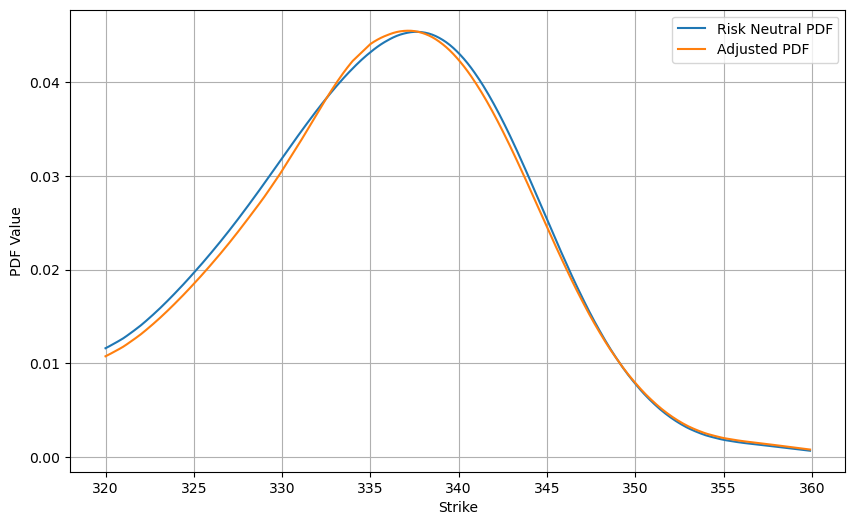

In [182]:
mask = (original_pdf2[:, 0] < 330) | (original_pdf2[:, 0] > 335)
filtered_x = original_pdf2[:, 0][mask]
filtered_y = original_pdf2[:, 1][mask]

interpolator = interp1d(filtered_x, filtered_y, kind='cubic', fill_value="extrapolate")

interpolated_x = np.linspace(331, 334, num=50)  
interpolated_y = interpolator(interpolated_x)

smoothed_x = np.concatenate((filtered_x[filtered_x <= 331], interpolated_x, filtered_x[filtered_x > 334]))
smoothed_y = np.concatenate((filtered_y[filtered_x <= 331], interpolated_y, filtered_y[filtered_x > 334]))
skewed_pdf = np.column_stack((smoothed_x, smoothed_y))

plt.figure(figsize=(10, 6))
plt.plot(original_pdf[:, 0], original_pdf[:, 1], label='Risk Neutral PDF')
plt.plot(skewed_pdf[:, 0], skewed_pdf[:, 1], label='Adjusted PDF')
plt.xlabel('Strike')
plt.ylabel('PDF Value')
plt.legend()
plt.grid(True)
plt.show()


As before, we compute the optimal payoff for a growth optimizing investor with the belief described above.

In [171]:
#COMPUTE THE GROWTH OPTIMIZER PAYOFF

# Interpolate the original PDF
original_pdf_interp = interp1d(rn_pdf[:, 0], rn_pdf[:, 1], bounds_error=False, fill_value=0)

# Divide the more volatile PDF by the interpolated original PDF
# Calculate the PDF values of the original PDF at the more volatile PDF's strike prices
original_pdf_values_at_less_skewed = original_pdf_interp(skewed_pdf[:, 0])

# Perform the division
division = skewed_pdf[:, 1] / np.where(original_pdf_values_at_less_skewed != 0, 
                                              original_pdf_values_at_less_skewed, 1)

# Create a function for the growth optimizer payoff
growth_optimizer_payoff_less_skewed = interp1d(skewed_pdf[:, 0], division, kind='linear', fill_value='extrapolate')

In [172]:
mask = (skewed_pdf[:, 0] < 322) | (skewed_pdf[:, 0] > 336)
x_smooth = skewed_pdf[:, 0][mask]
division_smooth = division[mask]
smoother_interpolator = interp1d(x_smooth, division_smooth, kind='cubic', fill_value='extrapolate')
x_to_replace = skewed_pdf[:, 0][(skewed_pdf[:, 0] >= 322) & (skewed_pdf[:, 0] <= 336)]
smoothed_division = smoother_interpolator(x_to_replace)
combined_x = np.concatenate((x_smooth[x_smooth < 328], x_to_replace, x_smooth[x_smooth > 336]))
combined_division = np.concatenate((division_smooth[x_smooth < 328], smoothed_division, division_smooth[x_smooth > 336]))
growth_optimizer_payoff_skewed = np.column_stack((combined_x, combined_division))
growth_optimizer_payoff_skew = interp1d(growth_optimizer_payoff_skewed[:, 0], division, kind='linear', fill_value='extrapolate')

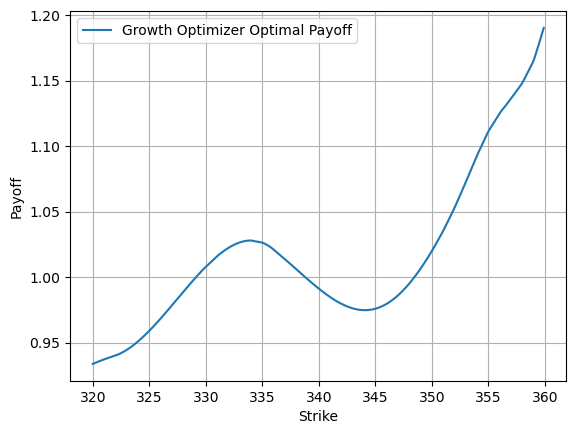

In [174]:
plt.plot(growth_optimizer_payoff_skewed[:, 0], growth_optimizer_payoff_skewed[:, 1], label='Growth Optimizer Optimal Payoff')
plt.xlabel('Strike')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()

We notice that the resulting payoff looks somewhat similar to that of a risk-reversal-type (with adjusted slope) or digital payoffs. The payoff of the structured product though seems to be more expressive of the specific beliefs of the investor both around the money and the tails.

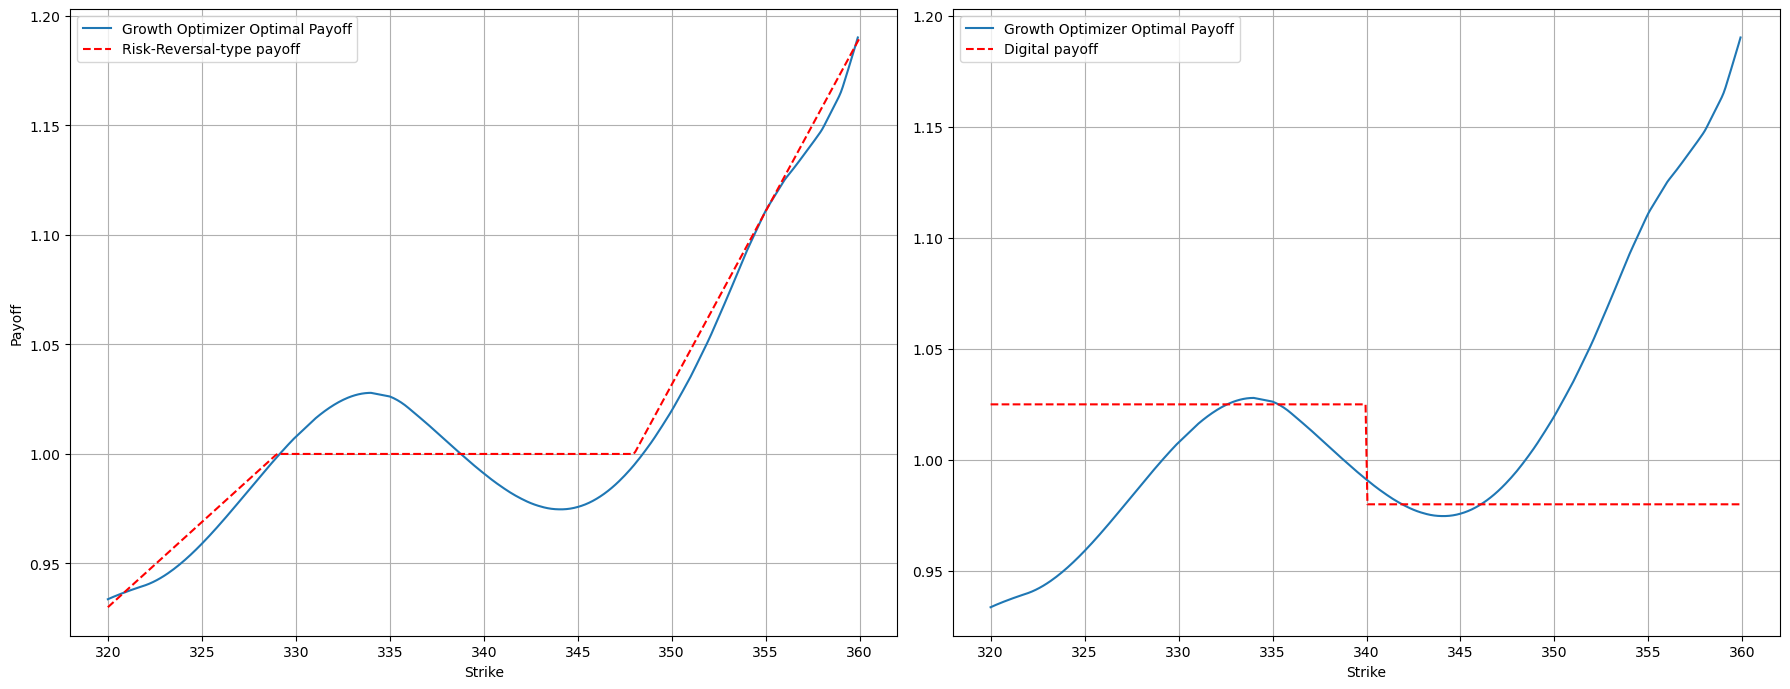

In [184]:
x_values = np.linspace(320, 360, 400)
vectorized_new_function = np.vectorize(risk_reversal_type_payoff)
y_values_new = vectorized_new_function(x_values)

vectorized_new_function2 = np.vectorize(digital_payoff)
y_values_new2 = vectorized_new_function2(x_values)

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.plot(growth_optimizer_payoff_skewed[:, 0], growth_optimizer_payoff_skewed[:, 1], label='Growth Optimizer Optimal Payoff')

plt.plot(x_values, y_values_new, linestyle='--', label='Risk-Reversal-type payoff', color='red')
plt.xlabel('Strike')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(growth_optimizer_payoff_skewed[:, 0], growth_optimizer_payoff_skewed[:, 1], label='Growth Optimizer Optimal Payoff')

plt.plot(x_values, y_values_new2, linestyle='--', label='Digital payoff', color='red')
plt.xlabel('Strike')
plt.legend()
plt.grid(True)

plt.tight_layout()  
plt.show()

### Risk aversion extraction

Now that we have established the growth optimal products for the scenarios we presented, we are ready to use our formulas to find the optimal payoffs for a client that doesn't only have a specific belief for the market, but also a given risk aversion, given as a Relative Risk Aversion (RRA) across moneyness which is implied by a utility function $U$ with the formula $R(x)=\frac{-xU''(x)}{U'(x)}$. This can be done using our formula $ \dfrac{dlnF}{dlnf} = \dfrac{1}{R} $ that connects the optimal payoff of the growth optimizing investor $f$, the risk appetite of the client $R$ and the optimal payoff $F$ of this client. Thus, given $f, R$ we can extract the structured product $F$.

Before doing that though, we would like to approach the problem in the opposite direction. What if we use the previous formula, but instead of $f, R$ we take as inputs $f, F$, where $F$ is the payoff of an existing product? Then we could extract a risk aversion function $R$. And what does this risk aversion represent? If we look back at how $f$ is constructed, we would realise that this $R$ would represent the risk appetite of an investor that has the market belief $b$ that lead to the construction of $f$ through the formula $f(x)=\frac{b(x)}{m(x)}$ (m is the risk neutral density) and who chooses to buy the product $F$. To state it more simply, the input is the belief and the preferred product and the output is the implied risk aversion.

As we will see by working with real world data though, it is hard to get consistent sensible risk aversion results.

The first step is to establish an investor belief. To do that, let's look back at some of the cases we encountered before. The scenarios we examined included:
1) Shifting the risk neutral pdf  
2) Inreasing the volatility  
3) Shifting to the right and reducing the volatility  
4) Reducing the skewness of the implied volatility  
As we showed before, each one of these cases gives rise to an optimal product for a growth optimizing investor with payoff $f$. Now for each one of these cases, we will try to extract the implied risk aversion across moneyness of an investor that has bought a reverse convertible note (RC)


In [141]:
def ratio_function(x, growth_optimizer_payoff):
    # Function to compute the derivative
    def derivative_of_growth_optimizer(x):
        return derivative(growth_optimizer_payoff, x, dx=1e-6)
    
    # Function to compute the ratio of the original function to its derivative
    original_value = growth_optimizer_payoff(x)
    derivative_value = derivative_of_growth_optimizer(x)
    return original_value / derivative_value if derivative_value != 0 else np.inf

In [142]:
def relative_risk_aversion(x, growth_optimizer_payoff, general_payoff_ratio):
    return ratio_function(x, growth_optimizer_payoff) * general_payoff_ratio(x)

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14448\3660744459.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion_rc = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, rc) for x in x_range]
C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14448\3660744459.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion_brc = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, brc) for x in x_range]


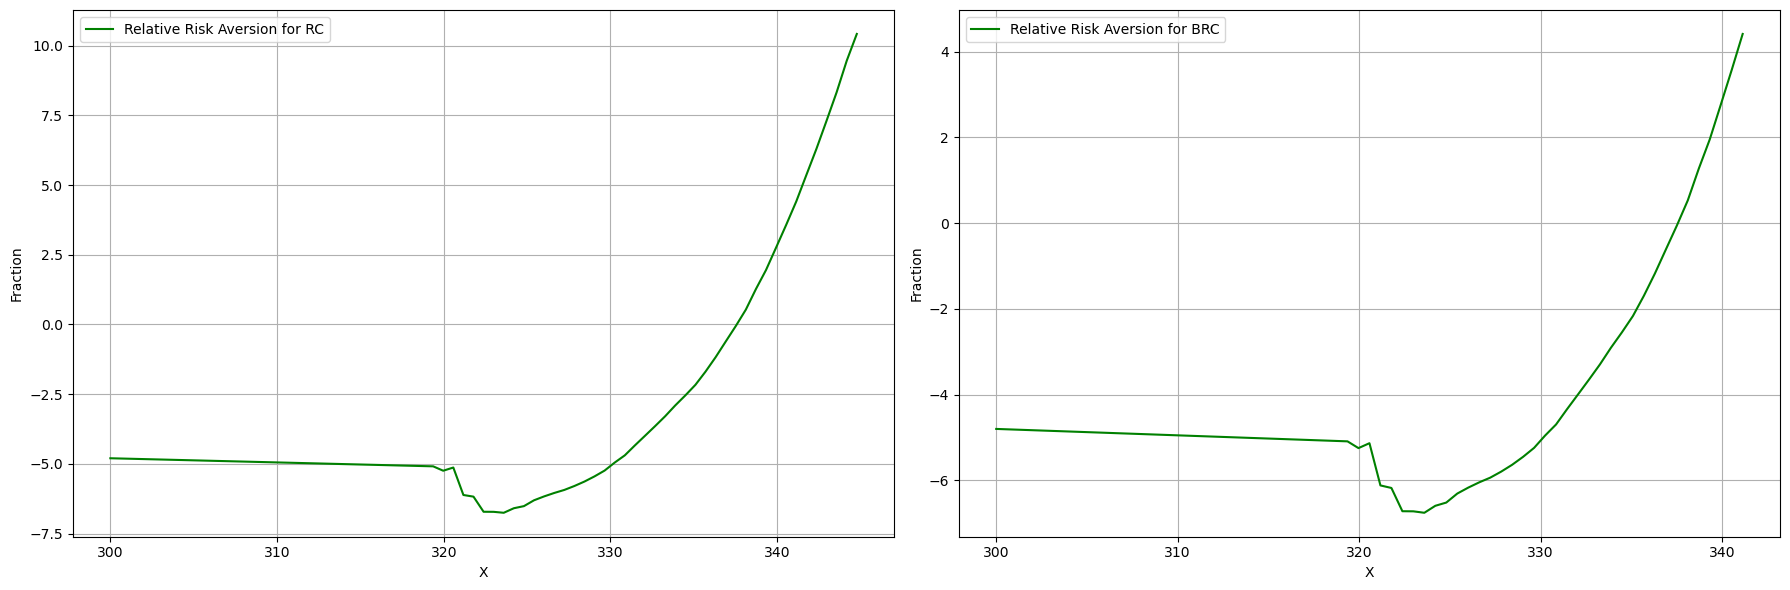

In [143]:
K = 345

def rc(x):
    return derivative_to_payoff_ratio_rc(x, K, K, 0.10*K, K) 

def brc(x):
    return derivative_to_payoff_ratio_brc(x, K, K, 0.10*K, K, 0.99*K)

x_range = np.linspace(np.min(growth_optimizer_payoff_vol.x), np.max(growth_optimizer_payoff_vol.x), 100)
risk_aversion_rc = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, rc) for x in x_range]
risk_aversion_brc = [1/relative_risk_aversion(x, growth_optimizer_payoff_vol, brc) for x in x_range]

# Create a figure with two subplots
plt.figure(figsize=(18, 6))  # Set the figure size to be wide enough for two subplots

# Plot for the existing function on the left
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(x_range, risk_aversion_rc, 'green', label='Relative Risk Aversion for RC')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

# Template for another graph on the right
plt.subplot(1, 2, 2) 
plt.plot(x_range, risk_aversion_brc, 'green', label='Relative Risk Aversion for BRC')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()  # Show the combined figure with both subplots


## Belief of a RC investor

C:\Users\ANDREAS\AppData\Local\Temp\ipykernel_14448\2662784032.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_rc, rv_fr) for x in x_range]


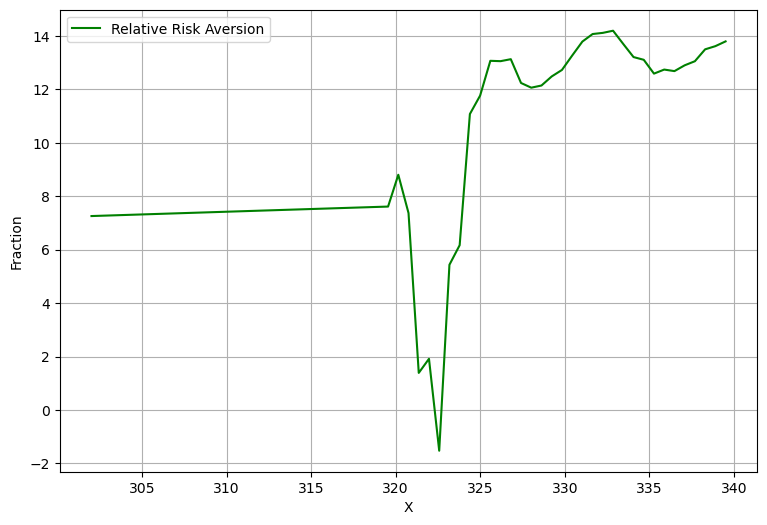

In [148]:
K = 340

def rv_fr(x):
    return derivative_to_payoff_ratio_rc(x, K, K, 0.10*K, K)  

x_range = np.linspace(np.min(growth_optimizer_payoff_rc.x), np.max(growth_optimizer_payoff_rc.x), 100)
risk_aversion = [1/relative_risk_aversion(x, growth_optimizer_payoff_rc, rv_fr) for x in x_range]

plt.figure(figsize=(9, 6))
plt.plot(x_range, risk_aversion, 'green', label='Relative Risk Aversion')
plt.xlabel("X")
plt.ylabel("Fraction")
plt.legend(loc="best")
plt.grid(True)

plt.show()


# Derivative Structuring

## Shift

In [154]:
def custom_risk_aversion1(x):
    c1 = 100
    c2 = 10
    c3 = 50
    a1 = (c2-c1)/4
    b1 = c2 - 332*a1
    a2 = (c3-c2)/4
    b2 = c3 - 352*a2
    
    if x < 328:
        return c1
    elif 328 <= x < 332:
        return a1*x+b1
    elif 332 <= x < 348:
        return c2
    elif 348 <= x < 352:
        return a2*x+b2
    else:
        return c3
    
def custom_risk_aversion2(x):
    return custom_risk_aversion1(x) + 5

def custom_risk_aversion3(x):
    return custom_risk_aversion1(x) - 5

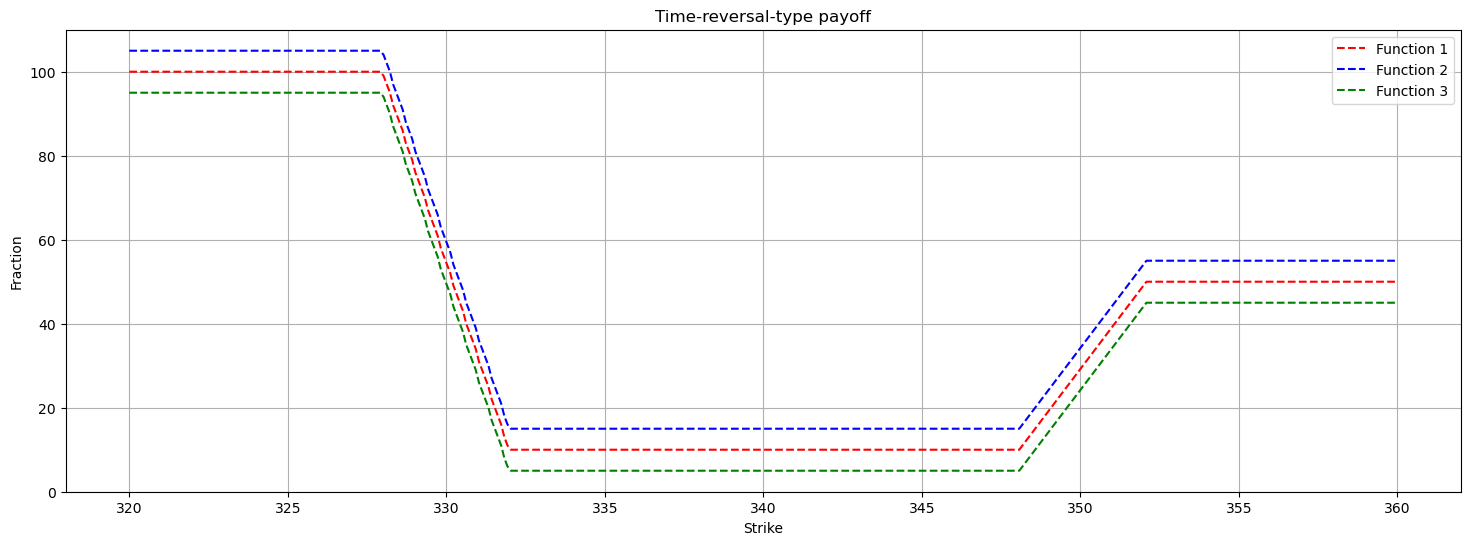

In [155]:
x_values = np.linspace(320, 360, 400)
vectorized_new_function3 = np.vectorize(custom_risk_aversion1)
y_values_new3 = vectorized_new_function3(x_values)
vectorized_new_function4 = np.vectorize(custom_risk_aversion2)
y_values_new4 = vectorized_new_function4(x_values)  # Corrected to use function4
vectorized_new_function5 = np.vectorize(custom_risk_aversion3)
y_values_new5 = vectorized_new_function5(x_values)  # Corrected to use function5

plt.figure(figsize=(18, 6))
plt.plot(x_values, y_values_new3, linestyle='--', label='Function 1', color='red')
plt.plot(x_values, y_values_new4, linestyle='--', label='Function 2', color='blue')
plt.plot(x_values, y_values_new5, linestyle='--', label='Function 3', color='green')

plt.xlabel('Strike')
plt.ylabel('Fraction')
plt.title('Time-reversal-type payoff')
plt.legend()
plt.grid(True)
plt.show()


In [254]:

def c_shift(x):
    f_interpolated = growth_optimizer_payoff_shift
    f_x = f_interpolated(x)
    f_prime_x = derivative(f_interpolated, x, dx=1e-6, n=1)

    return f_prime_x / f_x

def c_vol(x):
    f_interpolated = growth_optimizer_payoff_vol
    f_x = f_interpolated(x)
    f_prime_x = derivative(f_interpolated, x, dx=1e-6, n=1)

    return f_prime_x / f_x

def c_rc(x):
    f_interpolated = growth_optimizer_payoff_rc
    f_x = f_interpolated(x)
    f_prime_x = derivative(f_interpolated, x, dx=1e-6, n=1)

    return f_prime_x / f_x

def c_skew(x):
    f_interpolated = interp1d(growth_optimizer_payoff_skewed[:, 0], growth_optimizer_payoff_skewed[:, 1], kind='cubic', fill_value="extrapolate")
    f_x = f_interpolated(x)
    f_prime_x = derivative(f_interpolated, x, dx=1e-6, n=1)

    return f_prime_x / f_x

def R1(F):
    return custom_risk_aversion1(x)

def R2(F):
    return custom_risk_aversion2(x)

def R3(F):
    return custom_risk_aversion3(x)

def ode1_shift(x, F):
    return c_shift(x) * F / R1(F)

def ode2_shift(x, F):
    return c_shift(x) * F / R2(F)

def ode3_shift(x, F):
    return c_shift(x) * F / R3(F)

def ode1_vol(x, F):
    return c_vol(x) * F / R1(F)

def ode2_vol(x, F):
    return c_vol(x) * F / R2(F)

def ode3_vol(x, F):
    return c_vol(x) * F / R3(F)

def ode1_rc(x, F):
    return c_rc(x) * F / R1(F)

def ode2_rc(x, F):
    return c_rc(x) * F / R2(F)

def ode3_rc(x, F):
    return c_rc(x) * F / R3(F)

def ode1_skew(x, F):
    return c_skew(x) * F / R1(F)

def ode2_skew(x, F):
    return c_skew(x) * F / R2(F)

def ode3_skew(x, F):
    return c_skew(x) * F / R3(F)

# Initial condition (x0, F0)
x0 = 320 # Starting value of x
F0 = 0.95  # Initial value of F(x) at x0

x_end = 360  # End value of x
x_values1 = np.linspace(300, x_end, 100)  # Range of x values
x_values_shift = np.linspace(300, 359, 100)  # Range of x values
x_values2 = np.linspace(320, x_end, 100)  # Range of x values
x_values_rc = np.linspace(300, 358, 100)

# Solve the ODE
solution1_shift = solve_ivp(ode1_shift, [300, x_end], [1], t_eval=x_values_shift)
solution2_shift = solve_ivp(ode2_shift, [300, x_end], [1.01], t_eval=x_values_shift)
solution3_shift = solve_ivp(ode3_shift, [300, x_end], [0.99], t_eval=x_values_shift)
solution1_vol = solve_ivp(ode1_vol, [300, x_end], [1], t_eval=x_values1)
solution2_vol = solve_ivp(ode2_vol, [300, x_end], [0.99], t_eval=x_values1)
solution3_vol = solve_ivp(ode3_vol, [300, x_end], [1.0], t_eval=x_values1)
solution1_rc = solve_ivp(ode1_rc, [300, 359], [0.99], t_eval=x_values_rc)
solution2_rc = solve_ivp(ode2_rc, [300, 359], [1.05], t_eval=x_values_rc)
solution3_rc = solve_ivp(ode3_rc, [300, 359], [0.95], t_eval=x_values_rc)
solution1_skew = solve_ivp(ode1_skew, [320, x_end], [0.991], t_eval=x_values2)
solution2_skew = solve_ivp(ode2_skew, [320, x_end], [0.999], t_eval=x_values2)
solution3_skew = solve_ivp(ode3_skew, [320, x_end], [0.9908], t_eval=x_values2)


In [255]:
# Define a new function that applies the power transformation
def general_payoff_power_shift(x, gamma):
    return growth_optimizer_payoff_shift(x) ** (1 / gamma)

def general_payoff_power_vol(x, gamma):
    return growth_optimizer_payoff_vol(x) ** (1 / gamma)

def general_payoff_power_rc(x, gamma):
    return growth_optimizer_payoff_rc(x) ** (1 / gamma)

def general_payoff_power_skew(x, gamma):
    return growth_optimizer_payoff_skew(x) ** (1 / gamma)

def general_payoff_exponential_shift(x, gamma):
    return np.log(growth_optimizer_payoff_shift(x))/gamma

def general_payoff_exponential_vol(x, gamma):
    return np.log(growth_optimizer_payoff_vol(x))/gamma

def general_payoff_exponential_rc(x, gamma):
    return np.log(growth_optimizer_payoff_rc(x))/gamma

def general_payoff_exponential_skew(x, gamma):
    return np.log(growth_optimizer_payoff_skew(x))/gamma 

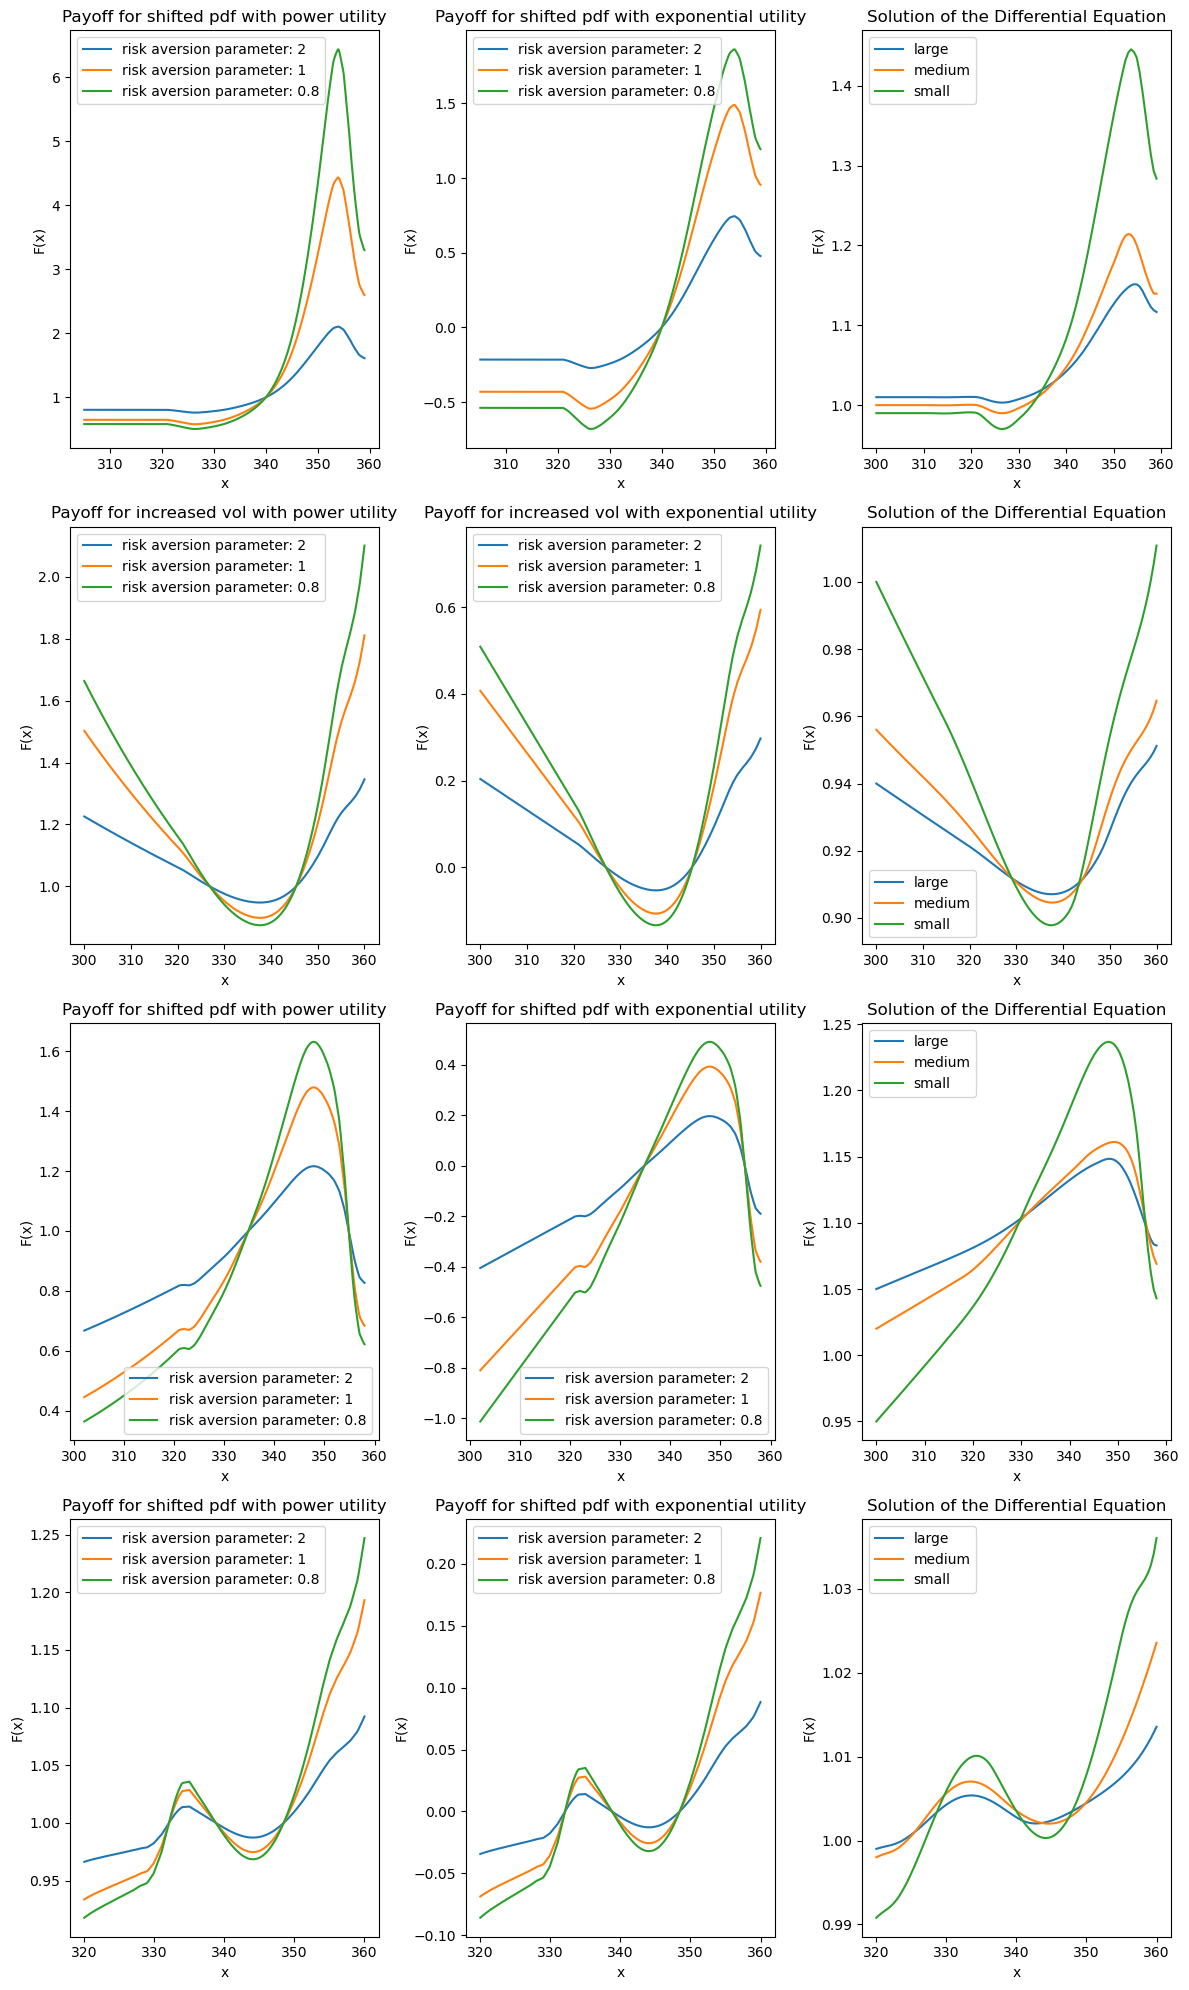

In [258]:
strike_range_shift = np.linspace(np.min(shifted_pdf[:, 0]), 359, 500)
strike_range_vol = np.linspace(np.min(more_volatile_pdf[:, 0]), end_range, 500)
strike_range_rc = np.linspace(np.min(rc_pdf[:, 0]), 358, 500)
strike_range_skew = np.linspace(np.min(skewed_pdf[:, 0]), end_range, 500)

plt.figure(figsize=(12, 20)) 

plt.subplot(4, 3, 1) 
plt.plot(strike_range_shift, general_payoff_power_shift(strike_range_shift, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_shift, general_payoff_power_shift(strike_range_shift, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_shift, general_payoff_power_shift(strike_range_shift, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with power utility')
plt.legend()

plt.subplot(4, 3, 2) 
plt.plot(strike_range_shift, general_payoff_exponential_shift(strike_range_shift, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_shift, general_payoff_exponential_shift(strike_range_shift, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_shift, general_payoff_exponential_shift(strike_range_shift, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with exponential utility')
plt.legend()

plt.subplot(4, 3, 3) 
plt.plot(solution2_shift.t, solution2_shift.y[0], label='large')
plt.plot(solution1_shift.t, solution1_shift.y[0], label='medium')
plt.plot(solution3_shift.t, solution3_shift.y[0], label='small')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Solution of the Differential Equation')
plt.legend()

plt.subplot(4, 3, 4) 
plt.plot(strike_range_vol, general_payoff_power_vol(strike_range_vol, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_vol, general_payoff_power_vol(strike_range_vol, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_vol, general_payoff_power_vol(strike_range_vol, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for increased vol with power utility')
plt.legend()

plt.subplot(4, 3, 5) 
plt.plot(strike_range_vol, general_payoff_exponential_vol(strike_range_vol, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_vol, general_payoff_exponential_vol(strike_range_vol, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_vol, general_payoff_exponential_vol(strike_range_vol, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for increased vol with exponential utility')
plt.legend()

plt.subplot(4, 3, 6) 
plt.plot(solution2_vol.t, solution2_vol.y[0]-0.05, label='large')
plt.plot(solution1_vol.t, solution1_vol.y[0]-0.044, label='medium')
plt.plot(solution3_vol.t, solution3_vol.y[0], label='small')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Solution of the Differential Equation')
plt.legend()

plt.subplot(4, 3, 7) 
plt.plot(strike_range_rc, general_payoff_power_rc(strike_range_rc, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_rc, general_payoff_power_rc(strike_range_rc, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_rc, general_payoff_power_rc(strike_range_rc, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with power utility')
plt.legend()

plt.subplot(4, 3, 8) 
plt.plot(strike_range_rc, general_payoff_exponential_rc(strike_range_rc, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_rc, general_payoff_exponential_rc(strike_range_rc, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_rc, general_payoff_exponential_rc(strike_range_rc, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with exponential utility')
plt.legend()

plt.subplot(4, 3, 9)
plt.plot(solution2_rc.t, solution2_rc.y[0], label='large')
plt.plot(solution1_rc.t, solution1_rc.y[0]+0.03, label='medium')
plt.plot(solution3_rc.t, solution3_rc.y[0], label='small')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Solution of the Differential Equation')
plt.legend()

plt.subplot(4, 3, 10) 
plt.plot(strike_range_skew, general_payoff_power_skew(strike_range_skew, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_skew, general_payoff_power_skew(strike_range_skew, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_skew, general_payoff_power_skew(strike_range_skew, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with power utility')
plt.legend()

plt.subplot(4, 3, 11) 
plt.plot(strike_range_skew, general_payoff_exponential_skew(strike_range_skew, 2), label='risk aversion parameter: 2')
plt.plot(strike_range_skew, general_payoff_exponential_skew(strike_range_skew, 1), label='risk aversion parameter: 1')
plt.plot(strike_range_skew, general_payoff_exponential_skew(strike_range_skew, 0.8), label='risk aversion parameter: 0.8')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Payoff for shifted pdf with exponential utility')
plt.legend()

plt.subplot(4, 3, 12) 
plt.plot(solution2_skew.t, solution2_skew.y[0], label='large')
plt.plot(solution1_skew.t, solution1_skew.y[0]+0.007, label='medium')
plt.plot(solution3_skew.t, solution3_skew.y[0], label='small')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('Solution of the Differential Equation')
plt.legend()

plt.tight_layout()  
plt.show()
